### Компьютерное зрение

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import lab4_util

Проверим доступность к CUDA:

In [2]:
print('CUDA is available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Number of available devices:', torch.cuda.device_count())
    print('Current device:', torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print('  ', i, ':', torch.cuda.get_device_name(0))

CUDA is available: True
Number of available devices: 1
Current device: 0
   0 : NVIDIA GeForce MX250


## Загрузка данных

In [4]:
train_dataset = torchvision.datasets.ImageFolder('data/pizza_not_pizza/train')
val_dataset = torchvision.datasets.ImageFolder('data/pizza_not_pizza/valid')

Некоторая статистика по наборам данных:

In [5]:
for dataset in train_dataset, val_dataset:
    print('Size:', len(dataset))
    print('Classes:', dataset.classes)

Size: 1966
Classes: ['not_pizza', 'pizza']
Size: 260
Classes: ['not_pizza', 'pizza']


In [6]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512>, 0)

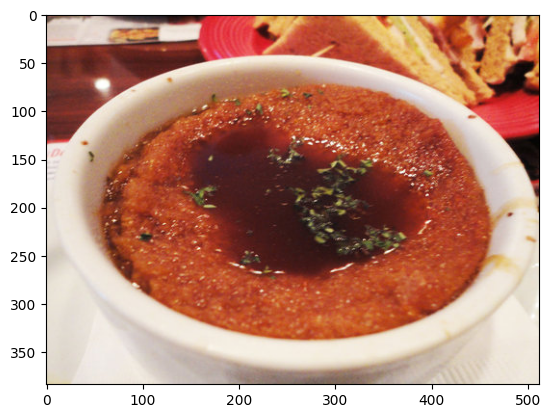

In [7]:
plt.imshow(train_dataset[4][0])

Преобразуем  в тензоры:

In [8]:
train_dataset.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)), torchvision.transforms.ToTensor()])
val_dataset.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)), torchvision.transforms.ToTensor()])

In [9]:
train_dataset[4][0].shape, train_dataset[4][0]

(torch.Size([3, 100, 100]),
 tensor([[[0.4745, 0.6000, 0.6039,  ..., 0.6784, 0.7216, 0.8510],
          [0.4784, 0.6745, 0.7608,  ..., 0.7412, 0.7529, 0.8588],
          [0.7451, 0.8549, 0.8706,  ..., 0.7725, 0.7451, 0.8824],
          ...,
          [0.8706, 0.8745, 0.8706,  ..., 0.9373, 0.9333, 0.9333],
          [0.8667, 0.8745, 0.8745,  ..., 0.9333, 0.9333, 0.9255],
          [0.8745, 0.8784, 0.8824,  ..., 0.9294, 0.9294, 0.9255]],
 
         [[0.3216, 0.4118, 0.4314,  ..., 0.5412, 0.5686, 0.6471],
          [0.3922, 0.5882, 0.6824,  ..., 0.5725, 0.5451, 0.6471],
          [0.6627, 0.7882, 0.8118,  ..., 0.5922, 0.4549, 0.6431],
          ...,
          [0.8353, 0.8392, 0.8431,  ..., 0.9137, 0.9059, 0.9020],
          [0.8353, 0.8392, 0.8392,  ..., 0.9098, 0.9098, 0.9020],
          [0.8275, 0.8353, 0.8314,  ..., 0.9059, 0.9059, 0.9020]],
 
         [[0.2471, 0.3020, 0.2941,  ..., 0.3608, 0.3137, 0.4078],
          [0.3451, 0.5373, 0.6235,  ..., 0.3412, 0.2549, 0.4039],
          [0

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [11]:
x, y = next(iter(train_loader))
print('X shape:', x.shape)
print('y shape:', y.shape)

X shape: torch.Size([32, 3, 100, 100])
y shape: torch.Size([32])


## Определение модели

In [12]:
class SimpleModel(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 10, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 1, kernel_size=1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(1),
            torch.nn.Linear(441, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Проверим, можно ли применить модель к батчу:

In [13]:
model = SimpleModel()
model(x)

tensor([[0.4873],
        [0.4722],
        [0.4703],
        [0.5076],
        [0.4739],
        [0.5089],
        [0.4967],
        [0.4805],
        [0.4845],
        [0.4679],
        [0.4877],
        [0.5020],
        [0.4889],
        [0.4580],
        [0.4817],
        [0.4869],
        [0.4786],
        [0.4724],
        [0.5104],
        [0.4764],
        [0.4962],
        [0.4840],
        [0.4903],
        [0.4847],
        [0.4720],
        [0.4784],
        [0.4886],
        [0.4953],
        [0.4984],
        [0.4783],
        [0.4912],
        [0.4991]], grad_fn=<SigmoidBackward0>)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

def train_epoch():
    total_loss = 0.0
    total_batches = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(X.to(device))
        loss = loss_fn(y_hat[:, 0], y.to(torch.float32).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().to('cpu')
        total_batches += 1
    return total_loss / total_batches

for epoch in range(5):
    train_loss = train_epoch()
    print(f'Epoch {epoch}: {train_loss}')

Epoch 0: 0.6621003150939941
Epoch 1: 0.6268050074577332
Epoch 2: 0.5920613408088684
Epoch 3: 0.5705475211143494
Epoch 4: 0.5240408182144165


In [15]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=25)   # Ограничение на количество эпох

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:29<00:00,  2.14it/s]


Epoch 0: train loss 0.67954
Epoch 0: val loss 0.68352


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.00it/s]


Epoch 1: train loss 0.64647
Epoch 1: val loss 0.66751


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 2: train loss 0.62618
Epoch 2: val loss 0.63628


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:29<00:00,  2.08it/s]


Epoch 3: train loss 0.58123
Epoch 3: val loss 0.59688


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:29<00:00,  2.07it/s]


Epoch 4: train loss 0.54752
Epoch 4: val loss 0.64191


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:28<00:00,  2.19it/s]


Epoch 5: train loss 0.47808
Epoch 5: val loss 0.48782


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.03it/s]


Epoch 6: train loss 0.40304
Epoch 6: val loss 0.42724


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:43<00:00,  1.42it/s]


Epoch 7: train loss 0.29024
Epoch 7: val loss 0.20438


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.90it/s]


Epoch 8: train loss 0.19813
Epoch 8: val loss 0.18115


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 9: train loss 0.14024
Epoch 9: val loss 0.11544


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.90it/s]


Epoch 10: train loss 0.08932
Epoch 10: val loss 0.06942


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.92it/s]


Epoch 11: train loss 0.05241
Epoch 11: val loss 0.04699


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.91it/s]


Epoch 12: train loss 0.03442
Epoch 12: val loss 0.03532


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 13: train loss 0.01559
Epoch 13: val loss 0.02824


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.85it/s]


Epoch 14: train loss 0.01673
Epoch 14: val loss 0.02630


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.94it/s]


Epoch 15: train loss 0.01914
Epoch 15: val loss 0.04432


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 16: train loss 0.07627
Epoch 16: val loss 0.10135


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.92it/s]


Epoch 17: train loss 0.07483
Epoch 17: val loss 0.10824


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.88it/s]


Epoch 18: train loss 0.04745
Epoch 18: val loss 0.04980


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 19: train loss 0.02064
Epoch 19: val loss 0.03202


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.92it/s]


Epoch 20: train loss 0.01042
Epoch 20: val loss 0.01952


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.88it/s]


Epoch 21: train loss 0.00654
Epoch 21: val loss 0.01864


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 22: train loss 0.00728
Epoch 22: val loss 0.02217


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 23: train loss 0.00653
Epoch 23: val loss 0.01755


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 24: train loss 0.00525
Epoch 24: val loss 0.01721


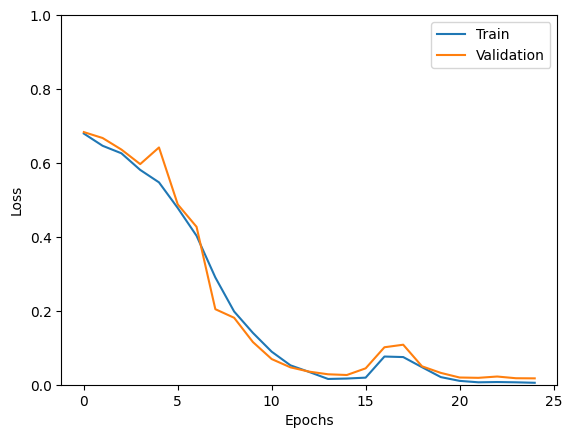

In [16]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

In [17]:
lab4_util.accuracy(model, val_loader)

1.0

Чем больше эпох тем ошибки на обучающем множестве стремятся к нулю.
Точность распознования = 100%. Проведём аугментации:

## Аугментации

- ColorJitter() - Произвольное изменение яркости, контрастности, насыщенности и оттенка изображения
- RandomRotation(15) - Поворот изображения в градусах
- RandomHorizontalFlip(0.5) - Перевернуть данное изображение по горизонтали случайным образом с заданной вероятностью в 50%

In [18]:
train_dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100, 100)),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ToTensor()
])

Обучаем модель:

In [19]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=25)   # Ограничение на количество эпох

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.00it/s]


Epoch 0: train loss 0.67785
Epoch 0: val loss 0.64586


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 1: train loss 0.66692
Epoch 1: val loss 0.63689


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.03it/s]


Epoch 2: train loss 0.64247
Epoch 2: val loss 0.65141


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 3: train loss 0.63340
Epoch 3: val loss 0.63641


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 4: train loss 0.61281
Epoch 4: val loss 0.62249


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 5: train loss 0.60379
Epoch 5: val loss 0.63908


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 6: train loss 0.59003
Epoch 6: val loss 0.61182


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 7: train loss 0.60372
Epoch 7: val loss 0.64464


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 8: train loss 0.58547
Epoch 8: val loss 0.60858


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 9: train loss 0.57237
Epoch 9: val loss 0.64384


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:43<00:00,  1.42it/s]


Epoch 10: train loss 0.57395
Epoch 10: val loss 0.59458


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 11: train loss 0.55995
Epoch 11: val loss 0.64583


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 12: train loss 0.55900
Epoch 12: val loss 0.62102


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 13: train loss 0.54401
Epoch 13: val loss 0.65720


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 14: train loss 0.55232
Epoch 14: val loss 0.59829


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 15: train loss 0.54124
Epoch 15: val loss 0.65687


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:36<00:00,  1.70it/s]


Epoch 16: train loss 0.51588
Epoch 16: val loss 0.63805


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:36<00:00,  1.69it/s]


Epoch 17: train loss 0.53216
Epoch 17: val loss 0.65726


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:37<00:00,  1.67it/s]


Epoch 18: train loss 0.51792
Epoch 18: val loss 0.62251


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 19: train loss 0.51264
Epoch 19: val loss 0.57867


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.88it/s]


Epoch 20: train loss 0.50452
Epoch 20: val loss 0.56933


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 21: train loss 0.50026
Epoch 21: val loss 0.59450


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 22: train loss 0.48144
Epoch 22: val loss 0.50033


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 23: train loss 0.48356
Epoch 23: val loss 0.53865


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 24: train loss 0.47314
Epoch 24: val loss 0.61261


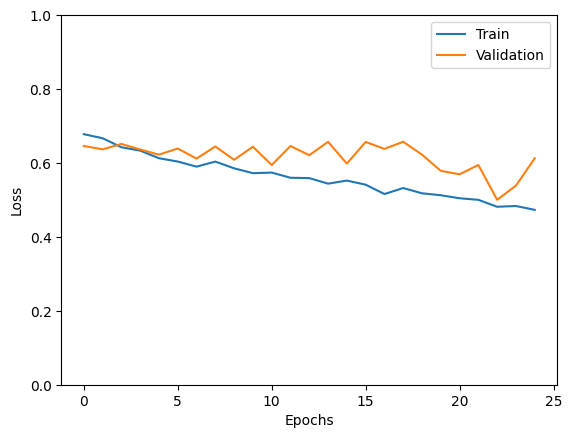

In [20]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))

In [21]:
lab4_util.accuracy(model, val_loader)

0.6375

Увеличим количество эпох в 2 раза:

In [22]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
history = lab4_util.train(model,           # Обучаемая модель
                          loss_fn,         # Функция потерь
                          optimizer,       # Оптимизатор
                          train_loader,    # Загрузчик данных обучающего множества
                          val_loader,      # Загрузчик данных множества валидации
                          max_epochs=50)   # Ограничение на количество эпох

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 0: train loss 0.67519
Epoch 0: val loss 0.61168


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 1: train loss 0.67602
Epoch 1: val loss 0.65834


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 2: train loss 0.64661
Epoch 2: val loss 0.61055


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 3: train loss 0.62378
Epoch 3: val loss 0.62028


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 4: train loss 0.61249
Epoch 4: val loss 0.62455


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 5: train loss 0.61272
Epoch 5: val loss 0.60548


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 6: train loss 0.60345
Epoch 6: val loss 0.58082


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 7: train loss 0.59309
Epoch 7: val loss 0.60770


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 8: train loss 0.59418
Epoch 8: val loss 0.61553


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 9: train loss 0.56780
Epoch 9: val loss 0.59290


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.05it/s]


Epoch 10: train loss 0.57101
Epoch 10: val loss 0.59887


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:40<00:00,  1.55it/s]


Epoch 11: train loss 0.57615
Epoch 11: val loss 0.58194


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 12: train loss 0.57359
Epoch 12: val loss 0.60578


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.91it/s]


Epoch 13: train loss 0.56478
Epoch 13: val loss 0.56722


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 14: train loss 0.55443
Epoch 14: val loss 0.60468


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 15: train loss 0.54085
Epoch 15: val loss 0.58001


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.88it/s]


Epoch 16: train loss 0.54567
Epoch 16: val loss 0.66310


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.85it/s]


Epoch 17: train loss 0.54298
Epoch 17: val loss 0.54371


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 18: train loss 0.53971
Epoch 18: val loss 0.53649


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.90it/s]


Epoch 19: train loss 0.53128
Epoch 19: val loss 0.53911


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 20: train loss 0.52429
Epoch 20: val loss 0.57937


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 21: train loss 0.51621
Epoch 21: val loss 0.56700


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 22: train loss 0.52158
Epoch 22: val loss 0.60190


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.88it/s]


Epoch 23: train loss 0.50497
Epoch 23: val loss 0.56148


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 24: train loss 0.49632
Epoch 24: val loss 0.59161


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 25: train loss 0.51410
Epoch 25: val loss 0.60798


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 26: train loss 0.49430
Epoch 26: val loss 0.49955


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.93it/s]


Epoch 27: train loss 0.48856
Epoch 27: val loss 0.50978


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 28: train loss 0.46609
Epoch 28: val loss 0.53306


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 29: train loss 0.47655
Epoch 29: val loss 0.48268


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 30: train loss 0.45616
Epoch 30: val loss 0.45556


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


Epoch 31: train loss 0.44568
Epoch 31: val loss 0.48271


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  2.00it/s]


Epoch 32: train loss 0.46592
Epoch 32: val loss 0.47715


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 33: train loss 0.45421
Epoch 33: val loss 0.42449


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 34: train loss 0.45919
Epoch 34: val loss 0.47682


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


Epoch 35: train loss 0.44690
Epoch 35: val loss 0.44802


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 36: train loss 0.43159
Epoch 36: val loss 0.46039


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 37: train loss 0.42672
Epoch 37: val loss 0.43228


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 38: train loss 0.43253
Epoch 38: val loss 0.46075


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 39: train loss 0.42280
Epoch 39: val loss 0.43472


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 40: train loss 0.41975
Epoch 40: val loss 0.43753


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.03it/s]


Epoch 41: train loss 0.41132
Epoch 41: val loss 0.47254


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 42: train loss 0.41587
Epoch 42: val loss 0.38893


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 43: train loss 0.39496
Epoch 43: val loss 0.39737


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 44: train loss 0.38882
Epoch 44: val loss 0.38094


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:32<00:00,  1.92it/s]


Epoch 45: train loss 0.39429
Epoch 45: val loss 0.35239


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 46: train loss 0.38319
Epoch 46: val loss 0.37550


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 47: train loss 0.36786
Epoch 47: val loss 0.34760


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.00it/s]


Epoch 48: train loss 0.36500
Epoch 48: val loss 0.34748


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:31<00:00,  1.99it/s]


Epoch 49: train loss 0.35663
Epoch 49: val loss 0.34190


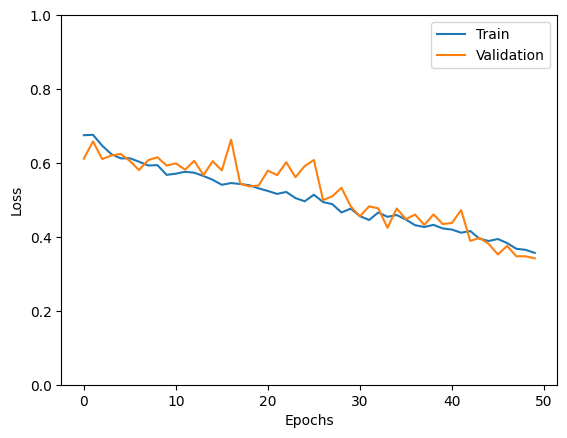

0.80625

In [23]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))
lab4_util.accuracy(model, val_loader)

Точность распознавания = 81% (увеличилась). 

- Epoch 0: train loss 0.675198    | Epoch 49: train loss 0.3566
- Epoch 0: val loss 0.611685      | Epoch 49: val loss 0.341900

Ошибка на обучающем и валидационном множестве уменьшается, соответственно модель обучается на данных изображениях.

## EfficientNet B0

In [24]:
import torchvision.models

In [25]:
ef_model = torchvision.models.efficientnet_b0(pretrained=True)
print(ef_model)

C:\Users\miste\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\miste\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Необходим 1 класс:

In [26]:
ef_model.classifier[1]
ef_model.classifier[1] = torch.nn.Linear(1280, 1)
ef_model.classifier[1]

for param in ef_model.parameters():
    param.requires_grad = False

for param in ef_model.features[8].parameters():
    param.requires_grad = True

Преобразуем обучающий и валидационный датасет + для модели необходимо применить сигмоидальную функцию активации к выходу сети.

In [27]:
train_dataset.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)), torchvision.transforms.ToTensor()])
val_dataset.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)), torchvision.transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

model_2 = torch.nn.Sequential(ef_model, torch.nn.Sigmoid())

In [28]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters())
history = lab4_util.train(model_2,        # Обучаемая модель
                          loss_fn,        # Функция потерь
                          optimizer,      # Оптимизатор
                          train_loader,   # Загрузчик данных обучающего множества
                          val_loader,     # Загрузчик данных множества валидации
                          max_epochs=5)   # Ограничение на количество эпох

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 0: train loss 0.44619
Epoch 0: val loss 0.24771


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 1: train loss 0.30042
Epoch 1: val loss 0.18965


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  3.00it/s]


Epoch 2: train loss 0.25270
Epoch 2: val loss 0.16008


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  3.02it/s]


Epoch 3: train loss 0.22427
Epoch 3: val loss 0.13997


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  3.05it/s]


Epoch 4: train loss 0.20583
Epoch 4: val loss 0.11742


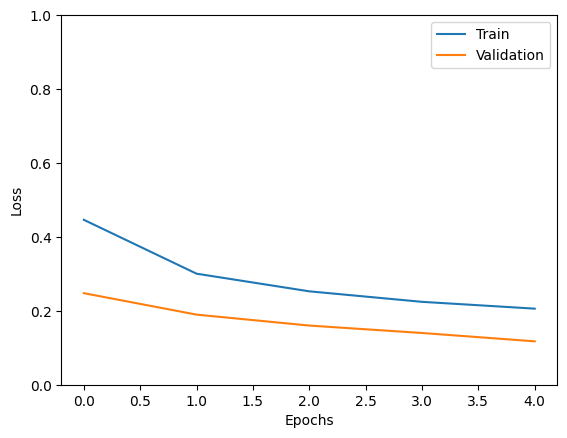

0.975

In [30]:
lab4_util.plot_history(history, 'loss', ylim=(0, 1.0))
lab4_util.accuracy(model_2, val_loader)